In [1]:
# Import our dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Fix a random seed so the data can be reproduced
np.random.seed(24)

# Upload and read the csv files
ais_df = pd.read_csv("ml_data_daily_2018.csv")

In [2]:
# Look at our data
ais_df.head()

,Unnamed: 0,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable
0,2018/01/01,9,37,145,44,27,13,12,7
1,2018/01/02,13,45,119,41,27,14,19,10
2,2018/01/03,13,44,106,40,36,14,20,11
3,2018/01/04,15,44,103,45,30,10,15,12
4,2018/01/05,10,45,107,41,26,13,21,10


In [3]:
# Renaming the "Unnamed:0" column to "Date"
ais_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
ais_df.head()

,Date,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable
0,2018/01/01,9,37,145,44,27,13,12,7
1,2018/01/02,13,45,119,41,27,14,19,10
2,2018/01/03,13,44,106,40,36,14,20,11
3,2018/01/04,15,44,103,45,30,10,15,12
4,2018/01/05,10,45,107,41,26,13,21,10


In [4]:
# Convert "Date" to datetime
ais_df['Date']=pd.to_datetime(ais_df['Date'])

In [5]:
# Creating a total column for our data
ais_df['Total']= ais_df.sum(numeric_only=True, axis=1)
ais_df.head()

,Date,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable,Total
0,2018-01-01,9,37,145,44,27,13,12,7,294
1,2018-01-02,13,45,119,41,27,14,19,10,288
2,2018-01-03,13,44,106,40,36,14,20,11,284
3,2018-01-04,15,44,103,45,30,10,15,12,274
4,2018-01-05,10,45,107,41,26,13,21,10,273


In [6]:
# And then check the type
ais_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          365 non-null    datetime64[ns]
 1   Fishing       365 non-null    int64         
 2   TugTow        365 non-null    int64         
 3   Recreational  365 non-null    int64         
 4   Passenger     365 non-null    int64         
 5   Cargo         365 non-null    int64         
 6   Tanker        365 non-null    int64         
 7   Other         365 non-null    int64         
 8   Unavailable   365 non-null    int64         
 9   Total         365 non-null    int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 28.6 KB


In [7]:
# Create nine DataFrames, each with the Date and one unique column:

# Fishing
ais_fishing_df = ais_df.loc[:, ['Date', 'Fishing']]
#ais_fishing_df = ais_df.loc[:, ['Fishing']]

# TugTow
ais_tugtow_df = ais_df.loc[:, ['Date', 'TugTow']]
#ais_tugtow_df = ais_df.loc[:, ['TugTow']]

# Recreational
ais_recreational_df = ais_df.loc[:, ['Date', 'Recreational']]
#ais_recreational_df = ais_df.loc[:, ['Recreational']]

# Passenger
ais_passenger_df = ais_df.loc[:, ['Date', 'Passenger']]
#ais_passenger_df = ais_df.loc[:, ['Passenger']]

# Cargo
ais_cargo_df = ais_df.loc[:, ['Date', 'Cargo']]
#ais_cargo_df = ais_df.loc[:, ['Cargo']]

# Tanker
ais_tanker_df = ais_df.loc[:, ['Date', 'Tanker']]
#ais_tanker_df = ais_df.loc[:, ['Tanker']]

# Other
ais_other_df = ais_df.loc[:, ['Date', 'Other']]
#ais_other_df = ais_df.loc[:, ['Other']]

# Unavailable
ais_unavailable_df = ais_df.loc[:, ['Date', 'Unavailable']]
#ais_unavailable_df = ais_df.loc[:, ['Unavailable']]

# Total
ais_total_df = ais_df.loc[:, ['Date', 'Total']]
#ais_total_df = ais_df.loc[:, ['Total']]

In [8]:
# We will be using 'Total' as an example, and repeating the code for the rest of the data

# Check the new DataFrame
ais_total_df

,Date,Total
0,2018-01-01,294
1,2018-01-02,288
2,2018-01-03,284
3,2018-01-04,274
4,2018-01-05,273
...,...,...
360,2018-12-27,298
361,2018-12-28,298
362,2018-12-29,306
363,2018-12-30,308


In [9]:
# From here, the code is heavily inspired by the code found on this site:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [10]:
# Convert the DataFrame into an array, and change the type to floats for the Neural Network
total = ais_total_df['Total'].values
total = total.astype('float32')
total = total.reshape((-1,1))

In [11]:
# Normalize the data by using a scaler
scaler = MinMaxScaler(feature_range=(0, 1))
total = scaler.fit_transform(total)

In [12]:
# Split our data into training and testing using slicing, and check the length

train_size = int(len(total) * 0.67)
test_size = len(total) - train_size
train, test = total[0:train_size,:], total[train_size:len(total),:]
print(len(train), len(test))

244 121


In [13]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
# Reshape the values into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [15]:
# Reshape the data to incorperate into the LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
242/242 - 1s - loss: 0.0789 - 1s/epoch - 5ms/step
Epoch 2/100
242/242 - 0s - loss: 0.0184 - 190ms/epoch - 787us/step
Epoch 3/100
242/242 - 0s - loss: 0.0160 - 306ms/epoch - 1ms/step
Epoch 4/100
242/242 - 0s - loss: 0.0148 - 198ms/epoch - 818us/step
Epoch 5/100
242/242 - 0s - loss: 0.0137 - 188ms/epoch - 778us/step
Epoch 6/100
242/242 - 0s - loss: 0.0127 - 188ms/epoch - 775us/step
Epoch 7/100
242/242 - 0s - loss: 0.0118 - 190ms/epoch - 783us/step
Epoch 8/100
242/242 - 0s - loss: 0.0111 - 188ms/epoch - 778us/step
Epoch 9/100
242/242 - 0s - loss: 0.0105 - 191ms/epoch - 788us/step
Epoch 10/100
242/242 - 0s - loss: 0.0101 - 192ms/epoch - 792us/step
Epoch 11/100
242/242 - 0s - loss: 0.0096 - 194ms/epoch - 801us/step
Epoch 12/100
242/242 - 0s - loss: 0.0094 - 193ms/epoch - 798us/step
Epoch 13/100
242/242 - 0s - loss: 0.0092 - 189ms/epoch - 783us/step
Epoch 14/100
242/242 - 0s - loss: 0.0092 - 188ms/epoch - 779us/step
Epoch 15/100
242/242 - 0s - loss: 0.0090 - 189ms/epoch - 779us/s

In [17]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

4/4 [==============================] - 0s 1ms/step


In [18]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [19]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.22 RMSE
Test Score: 21.46 RMSE


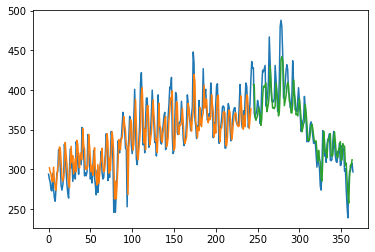

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(total)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(total)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(total)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(total))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [21]:
#total = total.reshape((-1))

def predict(num_prediction, model):
    prediction_list = total[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

def predict_dates(num_prediction):
    last_date = ais_total_df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 19ms/step


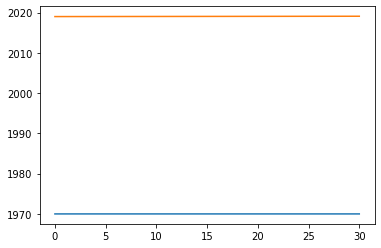

In [22]:
plt.plot(forecast)
plt.plot(forecast_dates)
plt.show()